# IDX Banking Stocks Forecast using Long Short-Term Memmory 2020-2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import keras
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

os.environ["KERAS_BACKEND"] = "torch"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(device)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print(device)
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

sns.set_theme(style="whitegrid")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
mps


## Load Dataset

In [2]:
banking_stocks = ['BBCA', 'BBNI', 'BBRI', 'BMRI']

stock_data = {}

for stock in banking_stocks: 
    data = pd.read_csv(f'data/{stock}_2023.csv', encoding='utf-8')
    data["Date"] = pd.to_datetime(data["Date"])
    
    stock_data[stock] = data

In [3]:
stock_data['BBCA'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,6695.0,6780.0,6680.0,6690.0,6029.958008,49445000
1,2020-01-03,6750.0,6800.0,6725.0,6800.0,6129.104492,47755500
2,2020-01-06,6720.0,6750.0,6690.0,6735.0,6070.518066,27300000
3,2020-01-07,6735.0,6770.0,6730.0,6740.0,6075.024902,45022500
4,2020-01-08,6670.0,6745.0,6670.0,6680.0,6020.943848,53692500


In [4]:
stock_data['BBCA'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       974 non-null    datetime64[ns]
 1   Open       974 non-null    float64       
 2   High       974 non-null    float64       
 3   Low        974 non-null    float64       
 4   Close      974 non-null    float64       
 5   Adj Close  974 non-null    float64       
 6   Volume     974 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.4 KB


## Data Visualization

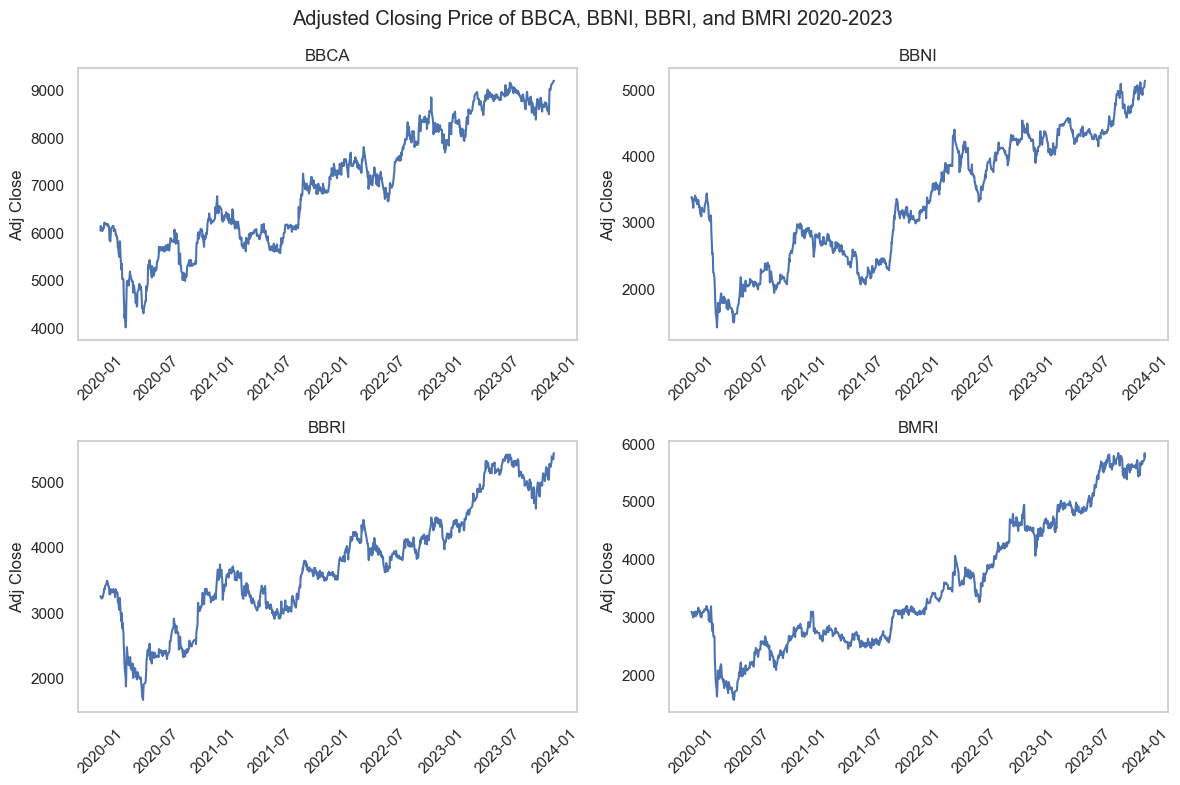

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle("Adjusted Closing Price of BBCA, BBNI, BBRI, and BMRI 2020-2023")

for (stock, df), ax in zip(stock_data.items(), axes.ravel()):
    ax.plot("Date", "Adj Close", data=df)
    ax.set_title(stock)
    ax.grid(False)
    ax.set_ylabel("Adj Close")
    ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout()
plt.show()

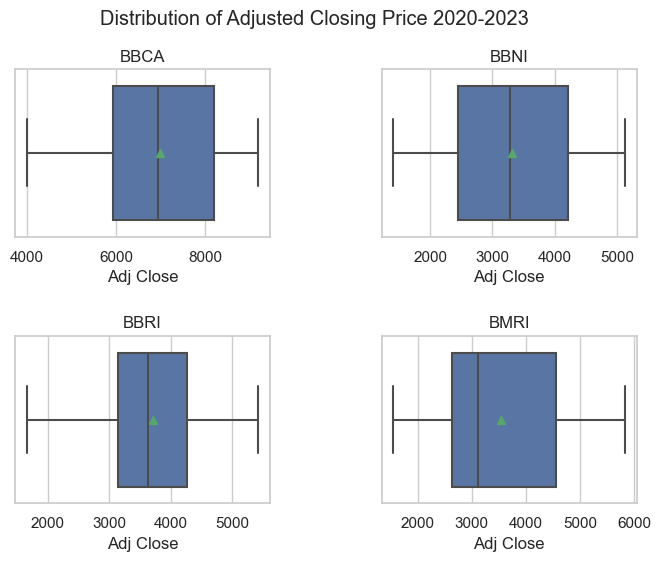

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.tight_layout(pad=4)

fig.suptitle("Distribution of Adjusted Closing Price 2020-2023")

for (stock, df), ax in zip(stock_data.items(), axes.ravel()):
    g = sns.boxplot(x="Adj Close", data=df, showmeans=True, ax=ax)
    g.set_title(stock, fontweight="normal")

plt.show()

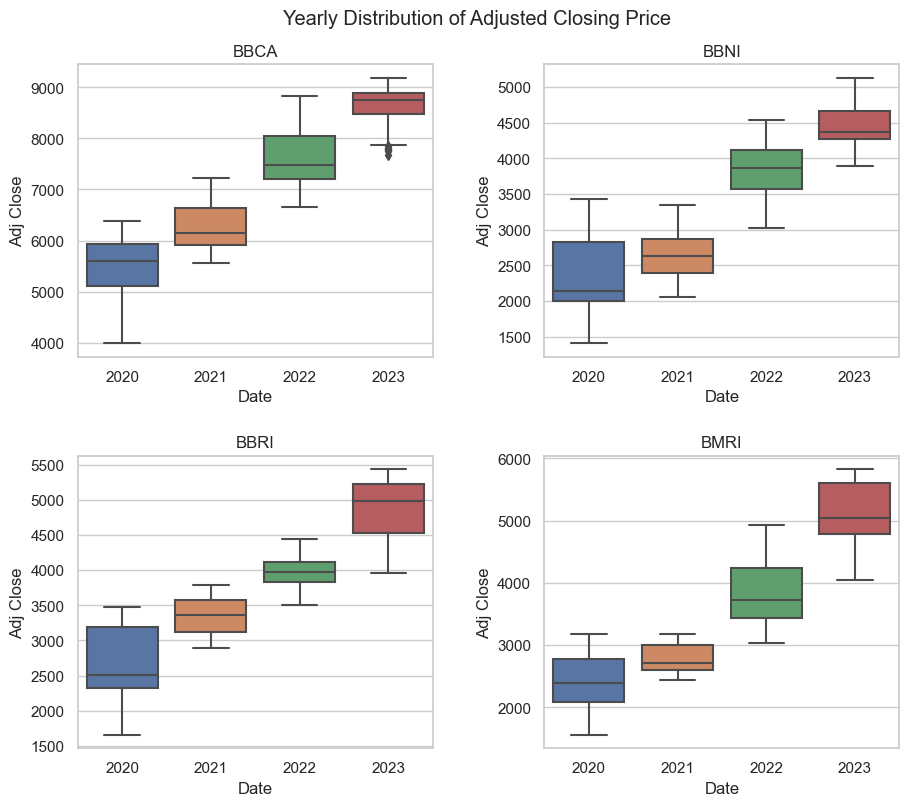

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8.5))
fig.tight_layout(pad=4)

fig.suptitle("Yearly Distribution of Adjusted Closing Price")

for (stock, df), ax in zip(stock_data.items(), axes.ravel()):
    g = sns.boxplot(x=df["Date"].dt.year, y=df["Adj Close"], data=df, ax=ax)
    g.set_title(stock, fontweight="normal")
    
plt.show()

## Time Series Component Decomposition

In [8]:
copy_stock_data = {}

for key, df in stock_data.items():
    new_df = df.copy()
    new_df.set_index('Date', inplace=True)
    copy_stock_data[key] = new_df
    
sns.set_theme(style="white")

In [9]:
def plot_decomposition(df, stock, col):
    advanced_decomposition = STL(df[col], period=4).fit()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)
    fig.suptitle(f"{stock} Decomposition")

    ax1.plot(advanced_decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(advanced_decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(advanced_decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(advanced_decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

### BBCA Decomposition

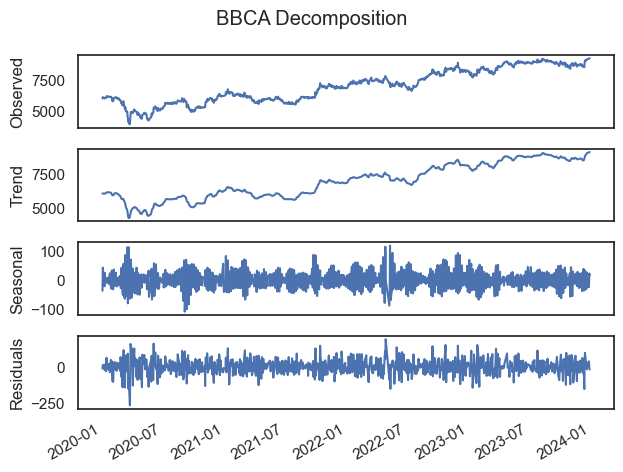

In [10]:
plot_decomposition(copy_stock_data["BBCA"], "BBCA", "Adj Close")

### BBNI Decomposition

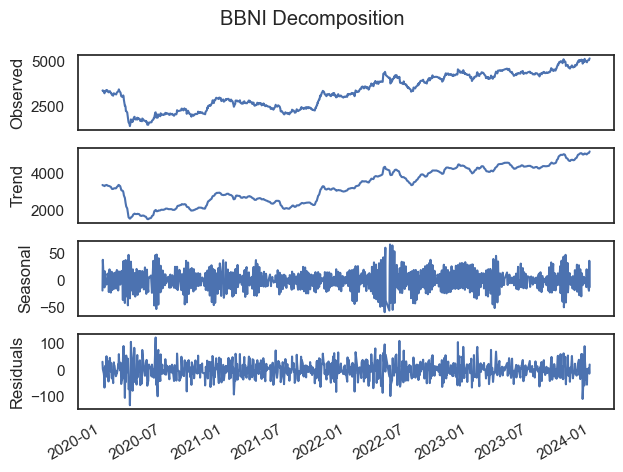

In [11]:
plot_decomposition(copy_stock_data["BBNI"], "BBNI", "Adj Close")

### BBRI Decomposition

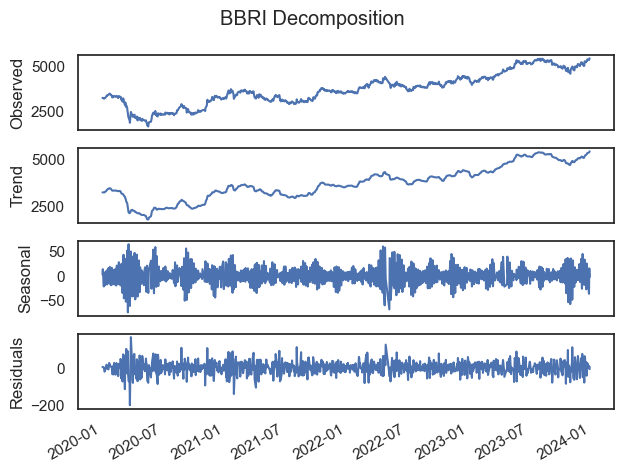

In [12]:
plot_decomposition(copy_stock_data["BBRI"], "BBRI", "Adj Close")

### BMRI Decomposition

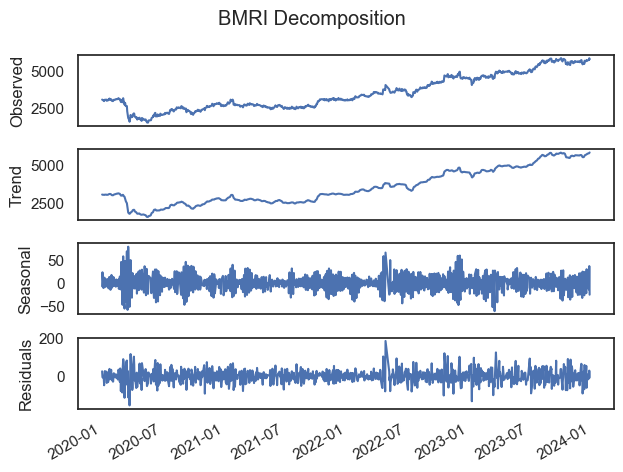

In [13]:
plot_decomposition(copy_stock_data["BMRI"], "BMRI", "Adj Close")

In [14]:
scaler = MinMaxScaler()
train_size = 80
seq_length = 60

num_epochs = 50
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
batch_size = 64

sns.set_theme(style="white")

## Modeling

In [15]:
# LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    
# load data
def load_data(stock, col):
    df = pd.read_csv(stock, parse_dates=['Date'])
    data = df[col].values.reshape(-1, 1)
    return data


# load model 
def load_model(model_path):
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model
   

# preprocessing
def preprocessing(data, seq_length, batch_size):
    data = scaler.fit_transform(data)
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    X, y = np.array(xs), np.array(ys)
    
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

    
# training dan evaluation
def train_and_evaluate(stock_name, model, criterion, optimizer, train_loader, test_loader, num_epochs):
    
    train_hist =[]
    test_hist =[]
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        average_loss = train_loss / len(train_loader)
        train_hist.append(average_loss)
        
        model.eval()
        eval_loss = 0.0
        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                eval_loss += loss.item()
        
        average_eval_loss = eval_loss / len(test_loader)
        test_hist.append(average_eval_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Stock: {stock_name}, Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Evaluation Loss: {average_eval_loss:.4f}')
    
    x = np.linspace(1, num_epochs, num_epochs)
    plt.plot(x, train_hist, scalex=True, label="Training loss")
    plt.plot(x, test_hist, label="Evaluation loss")
    plt.title(f'Training and Evaluation Loss of {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# prediction and plotting
def predict_and_plot(stock_path, stock_name, col, model_path):
    
    # read data
    df = pd.read_csv(stock_path, parse_dates=['Date'])
    data = df[col].values.reshape(-1, 1)
    dates = df['Date'].values
    
    # load model
    model = load_model(model_path)
    model.to(device)
    
    # preprocessing
    data = scaler.transform(data)
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    sequences = np.array(sequences)
    sequences = torch.Tensor(sequences).to(device)
    
    # prediction
    with torch.no_grad():
        predictions = model(sequences).cpu().numpy()
    predictions = scaler.inverse_transform(predictions)
    
    # plotting
    plt.figure(figsize=(10, 5))
    plt.plot(dates, df[col].values, label='Actual Data')
    plt.plot(dates[len(dates) - len(predictions):], predictions, label='Predicted Data')
    plt.title(f'Predictions for {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

## BBCA Forecasting

Stock: BBCA, Epoch [10/50] - Training Loss: 0.0021, Evaluation Loss: 0.0021
Stock: BBCA, Epoch [20/50] - Training Loss: 0.0012, Evaluation Loss: 0.0010
Stock: BBCA, Epoch [30/50] - Training Loss: 0.0012, Evaluation Loss: 0.0008
Stock: BBCA, Epoch [40/50] - Training Loss: 0.0012, Evaluation Loss: 0.0014
Stock: BBCA, Epoch [50/50] - Training Loss: 0.0011, Evaluation Loss: 0.0006


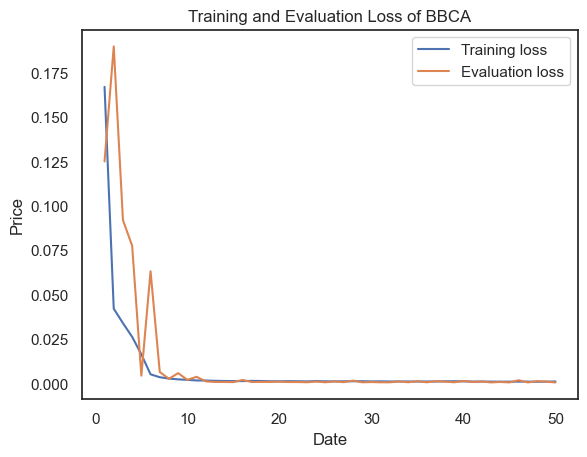

In [16]:
stock_name = 'BBCA'

data_path = f'data/{stock_name}_2023.csv'
model_path = f'models/{stock_name}_model.pth'
col = 'Adj Close'

data = load_data(data_path, col)

train_loader, test_loader = preprocessing(data, seq_length, batch_size)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_and_evaluate(stock_name, model, criterion, optimizer, train_loader, test_loader, num_epochs)

torch.save(model.state_dict(), model_path)

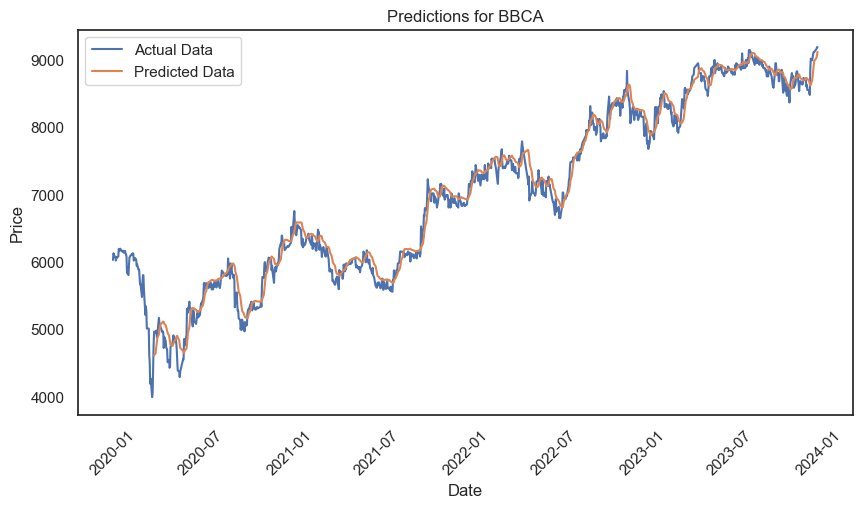

In [17]:
predict_and_plot(data_path, stock_name, col, model_path)

## BBNI Forecasting

Stock: BBNI, Epoch [10/50] - Training Loss: 0.0016, Evaluation Loss: 0.0020
Stock: BBNI, Epoch [20/50] - Training Loss: 0.0011, Evaluation Loss: 0.0010
Stock: BBNI, Epoch [30/50] - Training Loss: 0.0010, Evaluation Loss: 0.0007
Stock: BBNI, Epoch [40/50] - Training Loss: 0.0010, Evaluation Loss: 0.0007
Stock: BBNI, Epoch [50/50] - Training Loss: 0.0009, Evaluation Loss: 0.0011


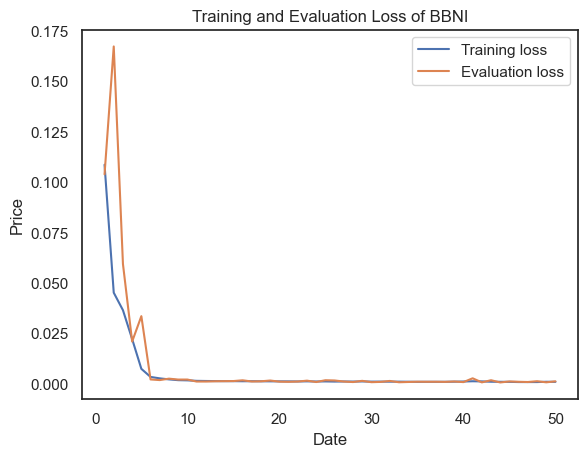

In [18]:
stock_name = 'BBNI'

data_path = f'data/{stock_name}_2023.csv'
model_path = f'models/{stock_name}_model.pth'
col = 'Adj Close'

data = load_data(data_path, col)

train_loader, test_loader = preprocessing(data, seq_length, batch_size)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_and_evaluate(stock_name, model, criterion, optimizer, train_loader, test_loader, num_epochs)

torch.save(model.state_dict(), model_path)

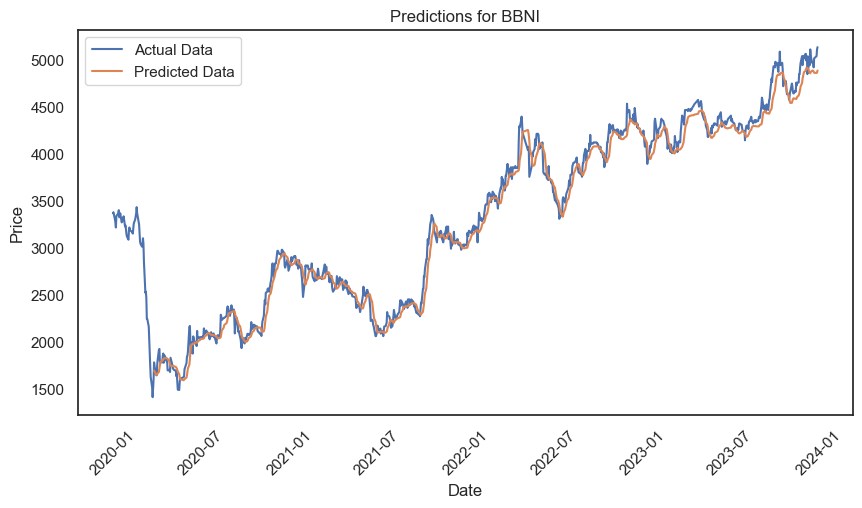

In [19]:
predict_and_plot(data_path, stock_name, col, model_path)

## BBRI Forecasting

Stock: BBRI, Epoch [10/50] - Training Loss: 0.0043, Evaluation Loss: 0.0016
Stock: BBRI, Epoch [20/50] - Training Loss: 0.0011, Evaluation Loss: 0.0039
Stock: BBRI, Epoch [30/50] - Training Loss: 0.0009, Evaluation Loss: 0.0009
Stock: BBRI, Epoch [40/50] - Training Loss: 0.0009, Evaluation Loss: 0.0008
Stock: BBRI, Epoch [50/50] - Training Loss: 0.0009, Evaluation Loss: 0.0008


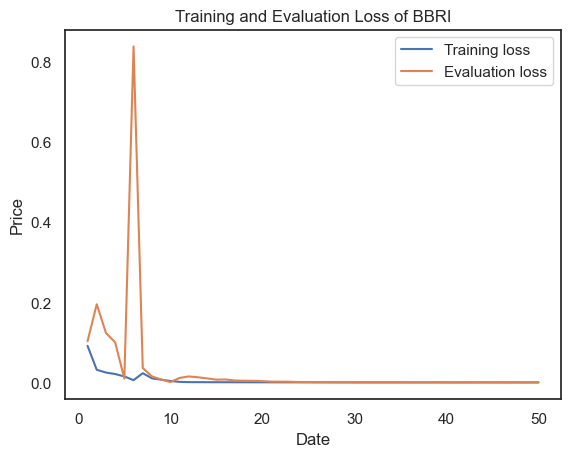

In [20]:
stock_name = 'BBRI'

data_path = f'data/{stock_name}_2023.csv'
model_path = f'models/{stock_name}_model.pth'
col = 'Adj Close'

data = load_data(data_path, col)

train_loader, test_loader = preprocessing(data, seq_length, batch_size)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_and_evaluate(stock_name, model, criterion, optimizer, train_loader, test_loader, num_epochs)

torch.save(model.state_dict(), model_path)

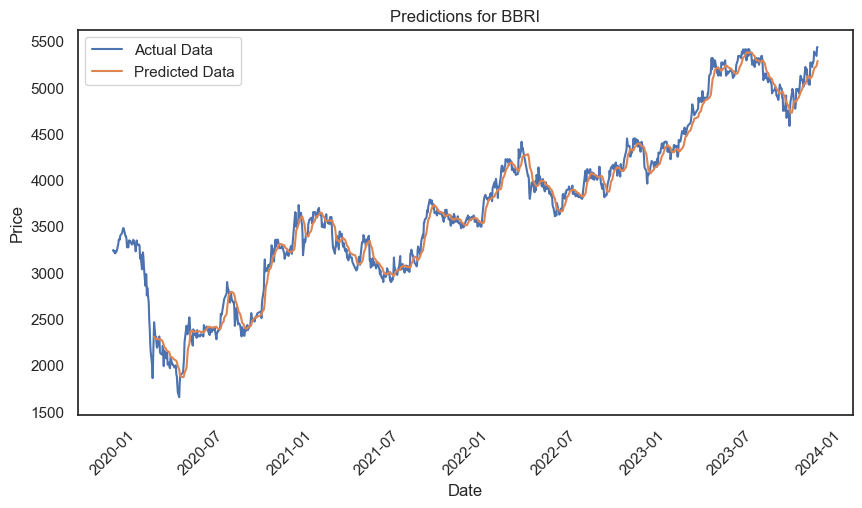

In [21]:
predict_and_plot(data_path, stock_name, col, model_path)

## BMRI Forecasting

Stock: BMRI, Epoch [10/50] - Training Loss: 0.0013, Evaluation Loss: 0.0012
Stock: BMRI, Epoch [20/50] - Training Loss: 0.0007, Evaluation Loss: 0.0019
Stock: BMRI, Epoch [30/50] - Training Loss: 0.0007, Evaluation Loss: 0.0023
Stock: BMRI, Epoch [40/50] - Training Loss: 0.0007, Evaluation Loss: 0.0016
Stock: BMRI, Epoch [50/50] - Training Loss: 0.0006, Evaluation Loss: 0.0011


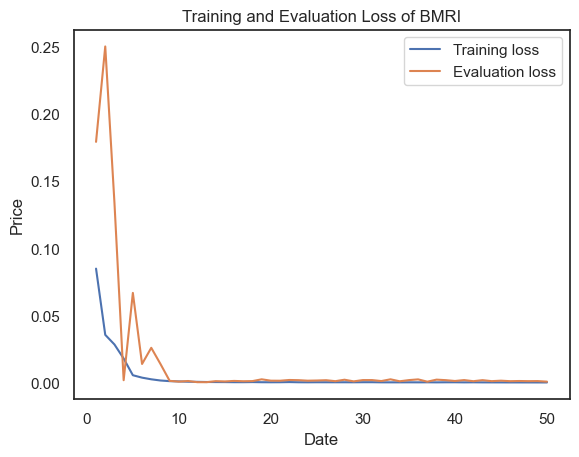

In [22]:
stock_name = 'BMRI'

data_path = f'data/{stock_name}_2023.csv'
model_path = f'models/{stock_name}_model.pth'
col = 'Adj Close'

data = load_data(data_path, col)

train_loader, test_loader = preprocessing(data, seq_length, batch_size)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_and_evaluate(stock_name, model, criterion, optimizer, train_loader, test_loader, num_epochs)

torch.save(model.state_dict(), model_path)

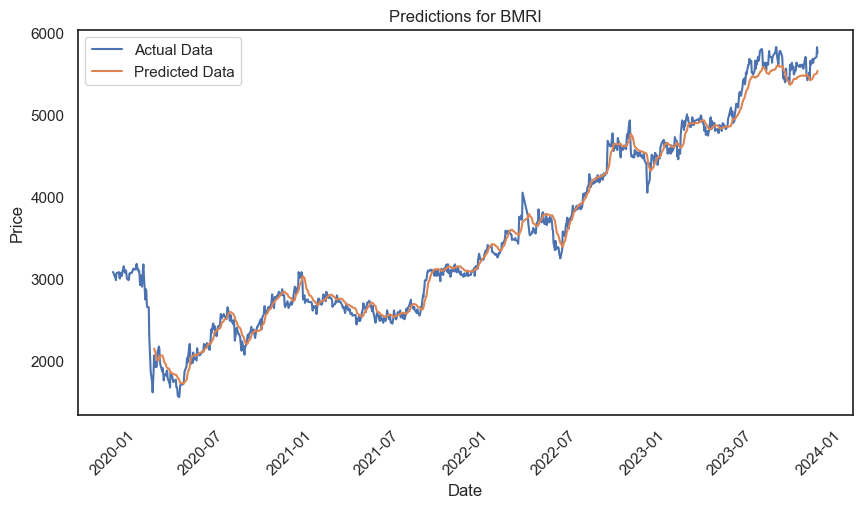

In [23]:
predict_and_plot(data_path, stock_name, col, model_path)